# Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for bioactivity inference.

In this notebook we showcase how to use `decoupler` for transcription factor (TF) and pathway activity inference from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
# Download data-set 
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']
adata.obs = adata.obs[columns]
adata.obs.columns = ['sex','individual','disease','cell_type']
adata

AnnData object with n_obs × n_vars = 6178 × 18958
    obs: 'sex', 'individual', 'disease', 'cell_type'

## Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

In [3]:
# Retrieve gene symbols
annot = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
    ).set_index("ensembl_gene_id")

# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
adata.var = adata.var.reset_index().rename(columns={'index': 'ensembl_gene_id'}).set_index('gene_symbol')

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicates
adata.var_names_make_unique()

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Since the meta-data of this data-set is available, we can filter cells that were not annotated:

In [4]:
# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()]

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [5]:
# Store raw counts in layers
adata.layers['counts'] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

We can also look how cells cluster by cell identity:

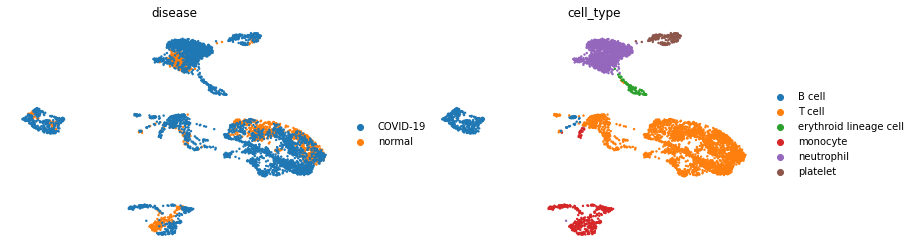

In [6]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=['disease','cell_type'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell indentities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterise them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same enviroment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach, which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Normalize aggregated counts.
5. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

A crucial step of pseudo-bulking is filtering out genes that are not expressed across most cells and samples, since they are very noisy and can result in unstable log fold changes.
`decoupler` has a helper function that performs pseudo-bulking. To get robust profiles, genes are filtered out if they are not expressed in an enough proportion of cells per sample (`min_prop`) and if this requirement is not true across enough samples (`min_smpls`).

In [7]:
# Get pseudo-bulk profile
padata = dc.get_pseudobulk(adata, sample_col='individual', groups_col='cell_type', layer='counts', min_prop=0.2, min_smpls=3)

# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
padata

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 26 × 6963
    obs: 'sex', 'individual', 'disease', 'cell_type'
    uns: 'log1p'

## Contrast between conditions
Once we have generated robust pseudo-bulk profiles for each sample and cell type, we can run any statistical test to compute DEA.
For this example we will use `t-test` as is implemented in `scanpy` but we could use any other.

In [8]:
logFCs, pvals = dc.get_contrast(padata, 
                                group_col='cell_type', 
                                condition_col='disease', 
                                condition='COVID-19', 
                                reference='normal',
                                method='t-test'
                               )
logFCs

,A1BG,AAGAB,AAK1,AAMP,AARS2,AATF,ABCA7,ABCB11,ABCB7,ABCC1,...,ZRANB2,ZRSR2,ZSCAN22,ZSWIM6,ZSWIM7,ZSWIM8,ZXDC,ZYG11B,ZYX,ZZEF1
B cell,-0.352016,0.000000,-0.720511,0.000000,-0.191943,-0.333673,0.000000,0.308509,0.000000,0.000000,...,-0.275637,0.031170,0.000000,0.00000,0.562253,0.000000,0.0000,0.806585,0.000000,0.090038
T cell,-0.174568,0.000000,-0.176686,0.000000,0.000000,0.076531,0.000000,0.144981,0.000000,0.000000,...,0.019278,0.072665,0.000000,0.00000,0.140914,0.000000,0.0000,0.281399,0.376813,0.020089
monocyte,-0.188902,-0.192955,0.134138,-0.071034,0.472479,-0.092681,-0.146258,0.157249,-0.160763,-0.747298,...,-0.123918,0.383032,-0.158732,0.36222,-0.153625,0.496824,0.0142,0.131526,0.445066,-0.162685
neutrophil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.057455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,-0.182189


For each cell type, we will obtain a log fold change (`logFC`) between conditions and their associated p-value (`pvals`).
These can be used to estimate biological activities such as TF or pathway activities. In this case, the obtained logFCs tell us what genes are changing in COVID compared to healthy.

We can plot the results of individual cell types in a volcano plot:

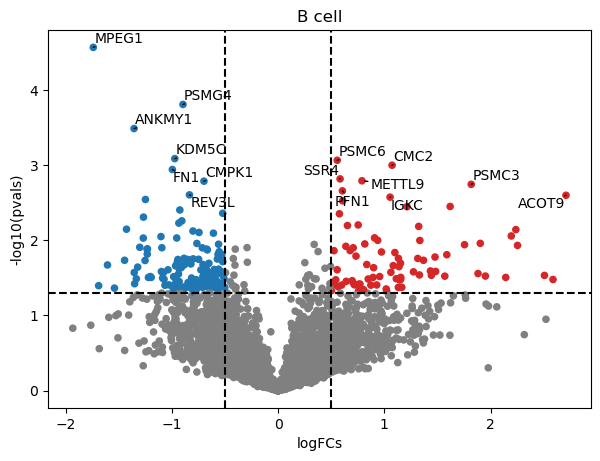

In [9]:
dc.plot_volcano(logFCs, pvals, 'B cell', top=15, sign_thr=0.05, lFCs_thr=0.5)

Optionaly, these results can also be transformed into a long format dataframe:

In [10]:
deg = dc.format_contrast_results(logFCs, pvals)
deg

,contrast,name,logFCs,pvals,adj_pvals
0,B cell,MPEG1,-1.739905,0.000027,0.18849
1,B cell,PSMG4,-0.895388,0.000156,0.54155
2,B cell,ANKMY1,-1.356016,0.000326,0.755645
3,B cell,KDM5C,-0.972460,0.000818,1.0
4,B cell,PSMC6,0.556979,0.000861,1.0
...,...,...,...,...,...
27847,neutrophil,NSD3,0.000000,1.000000,1.0
27848,neutrophil,SLX9,0.000000,1.000000,1.0
27849,neutrophil,CEP290,0.000000,1.000000,1.0
27850,neutrophil,SLX1B,0.000000,1.000000,1.0


To get and explore the list of significant genes of this plot we can additionaly use this line:

In [11]:
sign = dc.get_top_targets(logFCs, pvals, 'B cell', sign_thr=0.05, lFCs_thr=0.5)
sign

,contrast,name,logFCs,pvals,adj_pvals


Unfortunately, after FDR correction none of the genes are significant. Nonetheless, this level of significance is not requiered for footprint analysis so we will keep working with them.

## Pathway activity inference
To estimate pathway activities we will use the resource PROGENy and the `consensus` method. Moreover, we will run it using
the dense mode, meaning that only non-zero values are taken into account when estimating activities.

For another example on pathway activities please visit this other notebook: [Pathway activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html).

In [12]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=300)

# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.dense_run(dc.run_consensus, mat=logFCs, net=progeny, verbose=True)
pathway_acts

Dense run of consensus on mat with 4 samples and 6963 potential targets.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cell,-1.098919,1.237139,0.416324,-0.413475,1.445572,-0.700278,-0.618957,-0.873149,-1.344327,-0.240277,-0.237212,-0.270574,-1.992413,0.146785
T cell,0.366329,0.250877,0.681462,-0.256431,2.035453,-0.372100,-2.178579,0.011292,-0.826486,-0.875604,-0.011300,-0.256430,0.732481,-0.101372
monocyte,-0.722187,0.271530,0.198237,-0.950822,2.282387,-0.380224,-1.427933,0.212970,-0.460576,-1.226618,0.211401,0.292549,-0.448675,-1.140018
neutrophil,0.488334,-0.341408,0.115238,1.193122,0.531162,-0.591123,-1.618794,-0.768376,-0.470676,-0.644394,1.926585,-1.041501,0.099447,NaN


Let us plot the obtained scores:

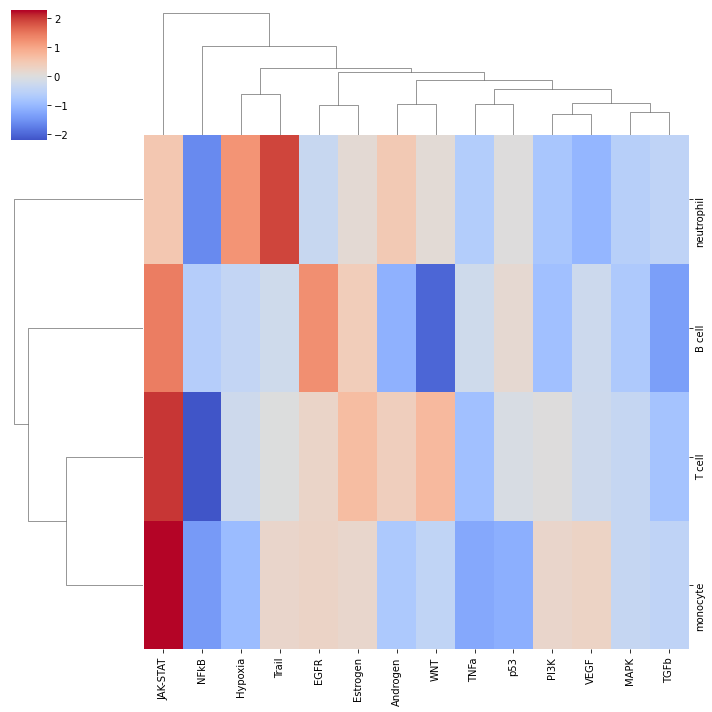

In [13]:
# Set nans to zero to be able to plot
pathway_acts.fillna(0, inplace=True)

sns.clustermap(pathway_acts, center=0, cmap='coolwarm')
plt.show()

It looks like JAK-STAT is active across cell types in COVID-19 compared to healthy. To further explore how the target genes behave, we can plot them in a volcano plot:

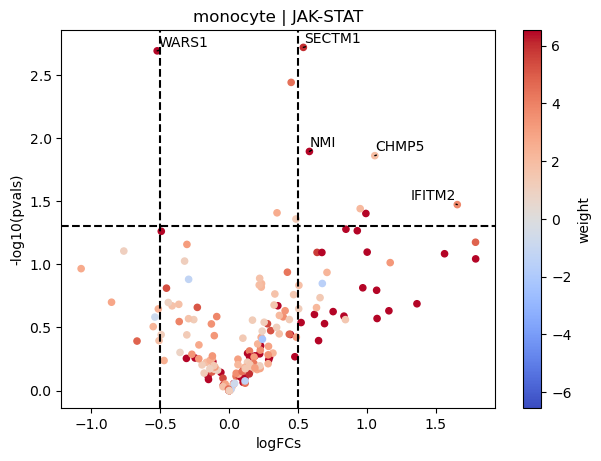

In [14]:
dc.plot_volcano(logFCs, pvals, 'monocyte', name='JAK-STAT', net=progeny, top=5, sign_thr=0.05, lFCs_thr=0.5)

As an example, we can see that most genes that belong to the JAK-STAT pathway appear to be unregulated in COVID-19 monocytes compared to healthy samples.

Here the weight is the mode of regulation of the pathway to the target genes. Positive means that if the pathway is active, we would expect them to show positive logFCs, and if it is inactive negative ones. If the mode of regulation is the opposite, then when the pathway is active, we would expect the logFCs to be negative. 

If needed, we can also retrieve the list of top target genes:

In [15]:
dc.get_top_targets(logFCs, pvals, 'monocyte', name='JAK-STAT', net=progeny, sign_thr=0.05, lFCs_thr=0.5, fdr_corr=False)

,contrast,name,logFCs,pvals
0,monocyte,SECTM1,0.537977,0.001906
1,monocyte,WARS1,-0.523153,0.002031
2,monocyte,NMI,0.582018,0.012736
3,monocyte,CHMP5,1.056818,0.013749
4,monocyte,IFITM2,1.655442,0.033603
5,monocyte,SPATS2L,0.950594,0.036179
6,monocyte,OAS3,0.992000,0.039488


Another example is the NFkB pathway:

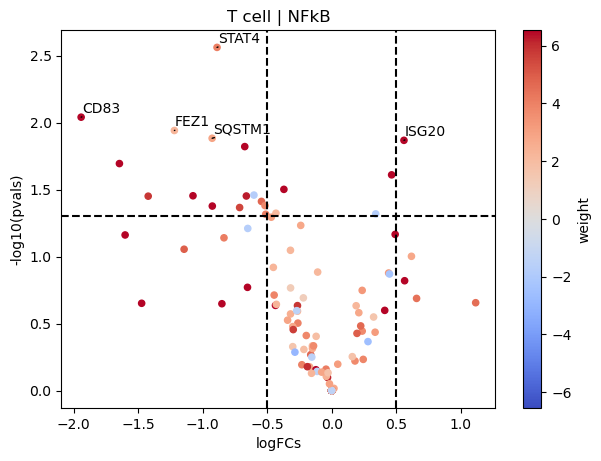

In [16]:
dc.plot_volcano(logFCs, pvals, 'T cell', name='NFkB', net=progeny, top=5, sign_thr=0.05, lFCs_thr=0.5)

Contrary to JAK-STAT, NFkB seems to be downregulated in T cells since most of its target genes are downregulated in COVID-19 samples compared to healthy ones.

## Transcription factor activity inference
Similarly to pathways, we can estimate transcription factor activities using the resource DoRothEA and the `consensus` method. 
As before, we will run it usingthe dense mode.

For another example on transcription factor activities please visit this other notebook: [Transcription factor activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

In [17]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea()

# Infer pathway activities with mlm
tf_acts, tf_pvals = dc.dense_run(dc.run_consensus, mat=logFCs, net=dorothea, verbose=True)
tf_acts

Dense run of consensus on mat with 4 samples and 6963 potential targets.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.82s/it]


,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,FOXL2,IRF8,MBD2,REL,RFX2,SIX5,ZNF197,ZNF24,ZNF584,ZNF644
B cell,-0.291513,-1.223751,0.076004,-0.096457,0.024240,-1.126016,-0.734804,0.139087,-2.183873,0.130307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T cell,-0.184412,0.710940,-1.238269,0.621122,0.491515,-1.802898,-0.523567,-0.573921,-2.350350,-0.802317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monocyte,2.120646,0.866575,-0.633623,-0.155740,0.699399,-0.383546,-0.473022,-0.313946,-1.981669,0.375956,...,-0.733783,0.207622,1.363607,-2.175412,0.087953,-0.225582,0.158962,-0.792434,0.704917,-0.96828
neutrophil,NaN,1.414255,NaN,NaN,NaN,NaN,NaN,0.074940,-0.506289,0.675885,...,-0.326009,NaN,NaN,-2.034404,NaN,NaN,NaN,NaN,NaN,NaN


Let us plot the obtained scores for the top active/inactive transcription factors:

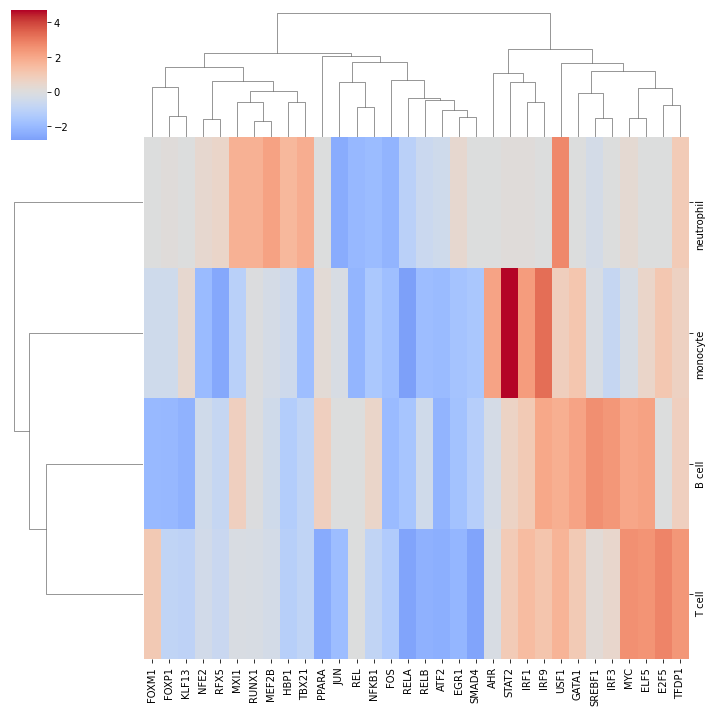

In [18]:
# Set nans to zero to be able to plot
tf_acts.fillna(0, inplace=True)

# Get top 10 most active/inactive sources
top = 10
top_idxs = set()
for row in tf_acts.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.update(sort_idxs[:top])
top_idxs = np.array(list(top_idxs))
top_names = tf_acts.columns[top_idxs]
names = tf_acts.index.values
top = pd.DataFrame(tf_acts.values[:,top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top, center=0, cmap='coolwarm')
plt.show()

In accordance to the previous pathway results, monocytes seem to activate the transcription factor STAT2.

Like with pathways, we can explore how the target genes look like:

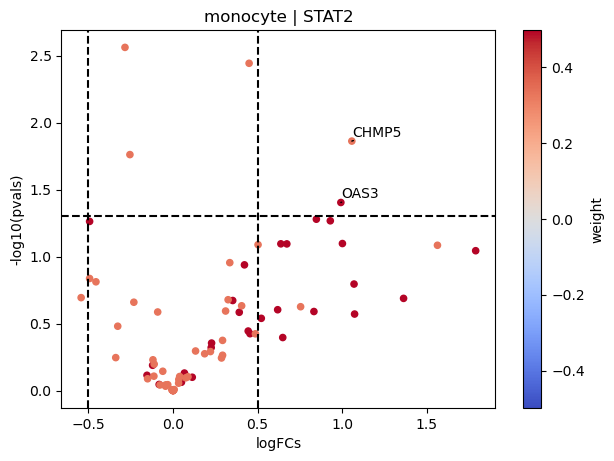

In [19]:
dc.plot_volcano(logFCs, pvals, 'monocyte', name='STAT2', net=dorothea, top=5, sign_thr=0.05, lFCs_thr=0.5)

STAT2 seems to be active in monocytes since their positive targets are up-regulated in COVID-19.

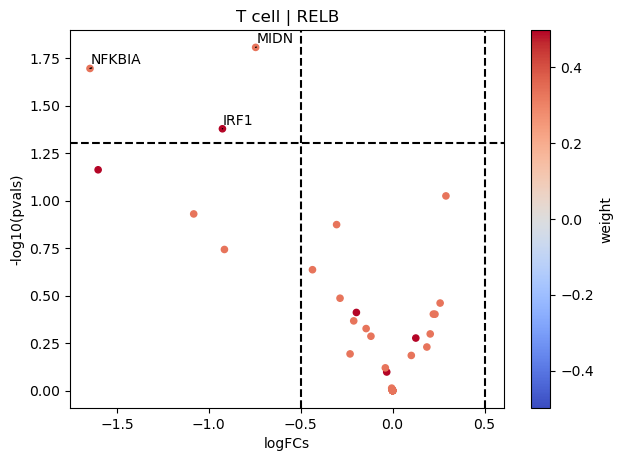

In [20]:
dc.plot_volcano(logFCs, pvals, 'T cell', name='RELB', net=dorothea, top=5, sign_thr=0.05, lFCs_thr=0.5)

On the other hand, RELB seems to be inactive in T cells since their positive targets are down-regulated in COVID-19.

Like before, we can also retrieve the list of top target genes if needed:

In [21]:
dc.get_top_targets(logFCs, pvals, 'T cell', name='RELB', net=dorothea, sign_thr=0.05, lFCs_thr=0.5, fdr_corr=False)

,contrast,name,logFCs,pvals
0,T cell,MIDN,-0.745112,0.015619
1,T cell,NFKBIA,-1.646185,0.020168
2,T cell,IRF1,-0.925865,0.041884


## Functional enrichment of biological terms
We can also assign the obtained DEG biological terms using the resource MSigDB and the `ora` method.

For another example on functional enrichment of biological terms please visit this other notebook: [Functional enrichment of biological terms](https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html).

In [22]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

# Filter by a desired geneset collection, for example hallmarks
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb = msigdb.drop_duplicates(['geneset', 'genesymbol'])

# Infer enrichment with ora using significant deg
top_genes = dc.format_contrast_results(logFCs, pvals)
top_genes = top_genes[(np.abs(top_genes['logFCs']) > 0.5) & (top_genes['pvals'] < 0.05)]
enr_pvals = dc.get_ora_df(top_genes, msigdb, groupby='contrast', features='name', source='geneset', target='genesymbol')
enr_pvals

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_APICAL_JUNCTION,HALLMARK_APOPTOSIS,HALLMARK_COMPLEMENT,HALLMARK_DNA_REPAIR,HALLMARK_E2F_TARGETS,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,...,HALLMARK_P53_PATHWAY,HALLMARK_PEROXISOME,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_XENOBIOTIC_METABOLISM
B cell,7.990353e-07,1.000000e+00,0.053091,2.578191e-04,0.000002,4.190804e-06,7.248452e-10,2.374115e-03,0.053091,8.358841e-02,...,1.068993e-07,0.073533,0.000068,1.988086e-07,0.073533,1.000000e+00,7.272781e-07,7.353273e-02,3.324869e-04,4.012057e-03
T cell,4.192186e-18,7.744216e-10,0.000053,3.619727e-10,0.000011,1.221818e-08,2.015566e-13,1.965194e-10,0.000053,7.744216e-10,...,3.619727e-10,0.000003,0.000283,4.421389e-03,0.000003,9.709890e-09,9.756507e-31,3.349332e-08,1.013992e-11,2.288820e-09
monocyte,1.000000e+00,6.111180e-02,0.000603,3.837896e-03,0.002126,7.476772e-05,9.592298e-03,5.368059e-02,0.038642,6.111180e-02,...,1.000000e+00,0.053681,0.061112,4.619094e-02,0.001253,4.619094e-02,1.649093e-03,5.368059e-02,1.281091e-04,2.126024e-03
neutrophil,1.000000e+00,7.178615e-03,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,7.178615e-03,...,1.074964e-02,0.006284,0.007179,1.000000e+00,1.000000,1.000000e+00,2.666968e-02,1.000000e+00,1.000000e+00,1.000000e+00


 We can then transform these p-values to their -log10 (so that the higher the value, the more significant the p-value).
 We will also set 0s to a minimum p-value so that we do not get infinites.

In [23]:
# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

Then we can visualize the most enriched terms:

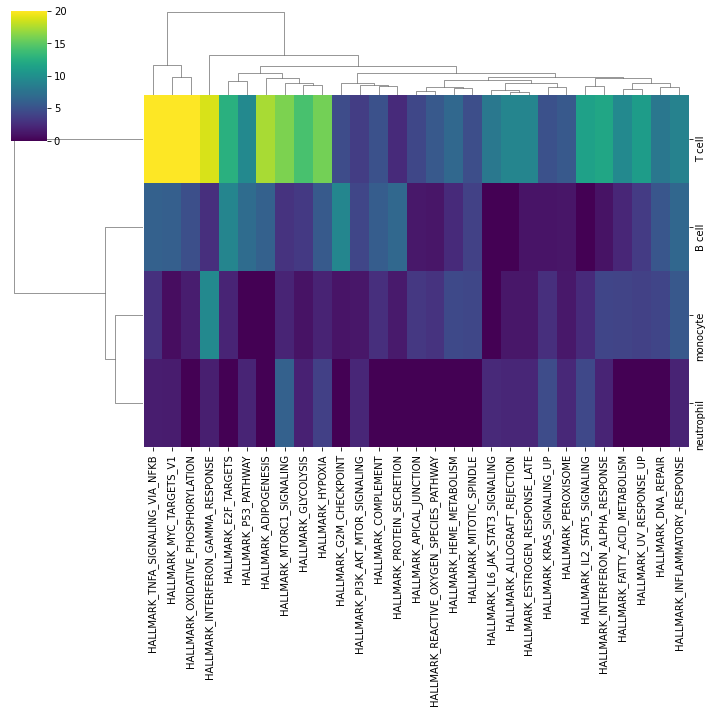

In [24]:
# Get top 10 most active/inactive sources
top = 10
top_idxs = set()
for row in enr_pvals.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.update(sort_idxs[:top])
top_idxs = np.array(list(top_idxs))
top_names = enr_pvals.columns[top_idxs]
names = enr_pvals.index.values
top = pd.DataFrame(enr_pvals.values[:, top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top, cmap='viridis', vmax=20)
plt.show()

We can also visualize the downstream targets of a specific term:

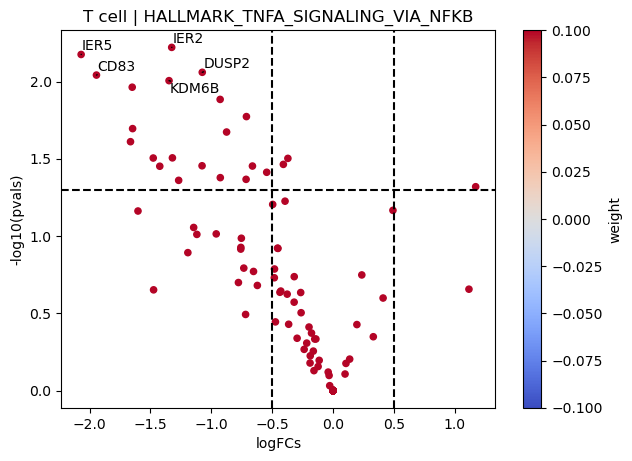

In [25]:
dc.plot_volcano(logFCs, pvals, 'T cell', name='HALLMARK_TNFA_SIGNALING_VIA_NFKB', net=msigdb, top=5, sign_thr=0.05, lFCs_thr=0.5, source='geneset', target='genesymbol', weight=None)